## Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import copy
from scipy.stats import moment
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Pytorch
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import statsmodels
import sklearn
from sklearn.metrics import mean_squared_error
import math
import plotly.express as px
import os
import random
os.chdir("/home/rodrigo/mount/home/rodrigo/git/neural_kaggle_store_item")

import plotly.graph_objects as go
import joypy
import time
import math
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from transformer.model import TransformerTimeSeries
from transformer.utils import TransformerSet, batch_train, batch_val
import seaborn as sns
import hiddenlayer as hl
import torchvision
import random

## Generate train and test sets
For a simple example lets generate sinusoid data to test with

In [3]:
def reset(percent=50):
    return random.randrange(100) < percent

def generate_random_fixed_autocorrelated_signal(percent_patern=0.5, n_samples=7000, seed=42, train_percent=0.6, val_percent=0.2, test_percent=0.2):
    random.seed(seed)
    signal = np.zeros(n_samples)

    for i in range(n_samples):
        # initialize patern
        if signal[i] == 0:
            if reset(percent=percent_patern):
                signal[i:i+150] = 1
                signal[i:i+10] = 50
                # Triangle rising part
                signal[i+30:i+80] = np.arange(len(signal[i+30:i+80]))

                # Fading part
                signal[i+80:i+130] = np.arange(len(signal[i+80:i+130] ))[::-1]

    data_train = signal[:int(train_percent * n_samples)]
    data_val   = signal[len(data_train) : len(data_train) +  int(val_percent * n_samples)]
    data_test  = signal[len(data_val): len(data_val) +  int(test_percent * n_samples)]

    return data_train, data_val, data_test


In [4]:
data_train, data_val, data_test = generate_random_fixed_autocorrelated_signal()
total_train = len(data_train)

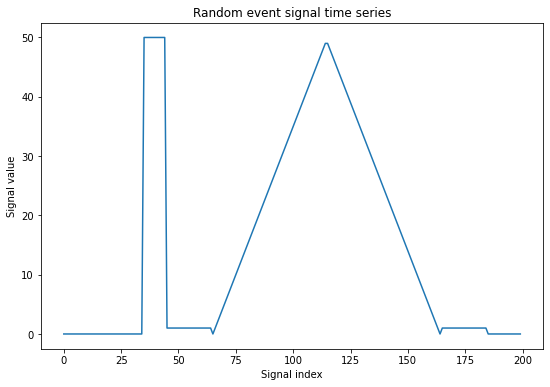

In [5]:
plt.rcParams["figure.figsize"] = (9,6)
plt.plot(data_train[:200])
plt.ylabel('Signal value')
plt.xlabel('Signal index')
plt.title("Random event signal time series")
plt.show()

## Rolling window approach

With this approach is possible to turn a series of data into a supervised learning problem, this way the model can intepretate the problem properly.

In [6]:
# Scaling the entry data
data_train   = data_train.reshape(-1,1)
# scaler        = StandardScaler()
scaler        = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data_train)

data_train = scaler.transform(data_train).flatten()
data_val   = scaler.transform(data_val.reshape(-1,1)).flatten()
index_val  = np.arange(len(data_train))


pred_horizon = 60
label_win = 60
feat_win  = 60
win_size  = label_win + feat_win
n_windows = total_train - win_size

In [7]:
def rolling_window(n_windows, feat_win, label_win, dataset):
    x_train = np.zeros((n_windows, int(feat_win + label_win)))
    x_id = np.zeros((n_windows, int(feat_win + label_win)))
    y_train = np.zeros((n_windows, feat_win + label_win))
    y_id = np.zeros((n_windows, feat_win + label_win))
    for win in range(n_windows):
        # Feature window start and end index
        i_s = win
        i_e = win + feat_win + label_win

        # Geting the past sales feature
        x_train[win][:feat_win] = dataset[i_s: i_e-label_win]
        x_id[win][:feat_win] = index_val[i_s: i_e-label_win]

        # Geting the weekdays feature
        # x_train[win][feat_win:] = weekday_train[i_s_label : i_e_label]

        # Since we want the weekdays to be corralated to the label values
        # the window of weekdays value that we will use will be the label's
        # weekday. This makes sense taking in count that we know the weekdays
        # beforehand

        # Geting the labels
        y_train[win] = data_train[i_s : i_e]
        y_id[win] = index_val[i_s : i_e]
    
    return x_train, x_id, y_train, y_id

In [8]:
x_train, x_id, y_train, y_id = rolling_window(n_windows, feat_win, label_win, data_train)

n_val_windows = len(data_val) - win_size
x_val, x_val_id, y_val, y_val_id= rolling_window(n_val_windows, feat_win, label_win, data_val)

In [9]:
x_id[0]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

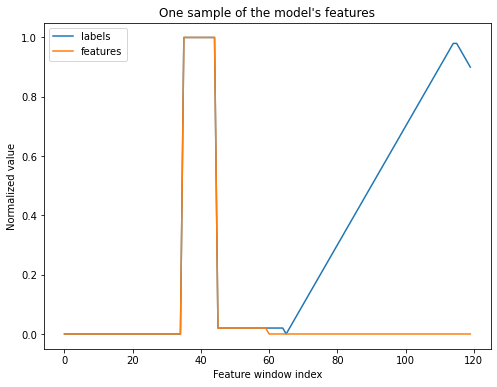

In [10]:
plt.rcParams["figure.figsize"] = (8,6)

plt.plot(y_train[0], label='labels')
plt.plot(np.arange(len(x_train[0])), x_train[0], label='features')
plt.ylabel('Normalized value')
plt.xlabel('Feature window index')
plt.title("One sample of the model's features")
plt.legend()
plt.show()


## Defining the model
The recommended neural network for a time series problem usualy is a LSTM, in this example peharps we will use a simple multi layer perceptron (MLP) model.

In [11]:
data_test   = data_test.reshape(-1,1)
data_test   = scaler.transform(data_test).flatten()

entry_test = np.zeros(int(feat_win+label_win))
entry_test[:feat_win] = data_val[-feat_win:]
entry_test[feat_win:] = data_test[:label_win]

label_test = copy.deepcopy(entry_test)
entry_test[feat_win:] = 0

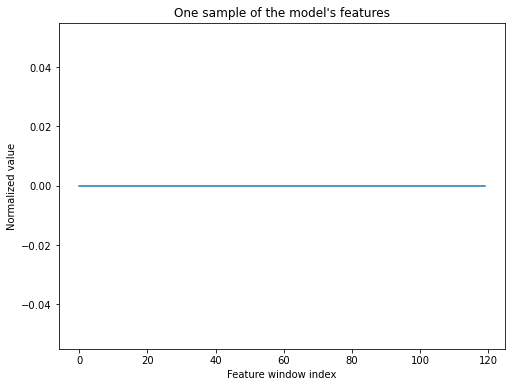

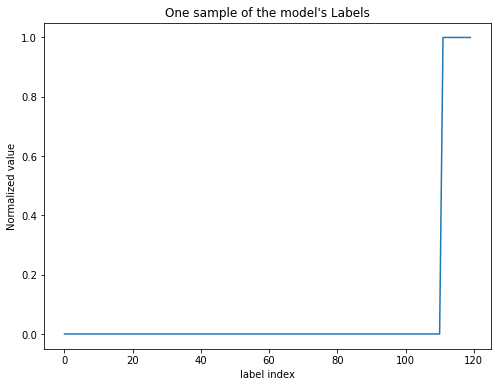

In [12]:
plt.plot(entry_test, label='features')
plt.ylabel('Normalized value')
plt.xlabel('Feature window index')
plt.title("One sample of the model's features")
plt.show()

plt.plot(label_test, label='labels')
plt.ylabel('Normalized value')
plt.xlabel('label index')
plt.title("One sample of the model's Labels")
plt.show()

## Transformer network

In [13]:
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [14]:
seed_torch(seed=234123)
# seed_torch(seed=42)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model = TransformerTimeSeries(device, dropout=0, d_model=64,
                              encoder_mask=True,
                              nhead=2,
                              encoder_only=True,
                              output_vector_sz=1,
                              iterative=False,
                              n_encoder_time_steps=feat_win+label_win,
                              n_input_time_steps=feat_win,
                              n_enc_layers=1
                             ).to(device)

criterion = nn.MSELoss()
lr = 0.0005
batch_size= 60
epochs = 30
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

Using device: cuda


In [16]:
train_set = TransformerSet(x_train, y_train, x_train.shape[1], encoder_only=True)
val_set = TransformerSet(x_val, y_val, x_val.shape[1], encoder_only=True)
test_set  = TransformerSet(np.array([entry_test]),np.array([label_test]), x_train.shape[1], encoder_only=True)

train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True,)
val_loader = DataLoader(val_set,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(test_set,
                          batch_size=batch_size,
                          shuffle=False)

In [17]:
src, true_target = next(iter(train_loader))
src = src.to(torch.float32)
src = src.to(device)
src.shape

torch.Size([60, 120, 1])

In [18]:
src.dtype
model.n_encoder_time_steps

120

In [19]:
out = model(src)
out.shape

torch.Size([60, 120])

In [20]:
loss = []
val_loss = []
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    epoch_loss = batch_train(model, epoch, batch_size, train_loader, criterion, optimizer, scheduler,  
                             y_train.shape[0], 
                             device, encoder_only=True, 
                             informer_pred_sz=label_win)
    val_epoch_loss = batch_val(model, val_loader, 
                               criterion, device, 
                               encoder_only=True, 
                               informer_pred_sz=label_win) 
    loss.append(epoch_loss)
    val_loss.append(val_epoch_loss)
    scheduler.step()


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |    13/   68 batches | lr 0.000500 | 84.56 ms | loss 0.25371
| epoch   1 |    26/   68 batches | lr 0.000500 | 68.41 ms | loss 0.12631
| epoch   1 |    39/   68 batches | lr 0.000500 | 59.53 ms | loss 0.11426
| epoch   1 |    52/   68 batches | lr 0.000500 | 65.68 ms | loss 0.11490
| epoch   1 |    65/   68 batches | lr 0.000500 | 66.90 ms | loss 0.11071
| epoch   2 |    13/   68 batches | lr 0.000480 | 70.74 ms | loss 0.11846
| epoch   2 |    26/   68 batches | lr 0.000480 | 71.46 ms | loss 0.10068
| epoch   2 |    39/   68 batches | lr 0.000480 | 75.66 ms | loss 0.08877
| epoch   2 |    52/   68 batches | lr 0.000480 | 71.35 ms | loss 0.09393
| epoch   2 |    65/   68 batches | lr 0.000480 | 72.47 ms | loss 0.08613
| epoch   3 |    13/   68 batches | lr 0.000471 | 74.59 ms | loss 0.08563
| epoch   3 |    26/   68 batches | lr 0.000471 | 72.08 ms | loss 0.06860
| epoch   3 |    39/   68 batches | lr 0.000471 | 69.57 ms | loss 0.06275
| epoch   3 |    52/   68 batches | lr

In [21]:
plot_df ={'loss': loss,
          'val_loss': val_loss,
         'epochs': np.arange(len(loss))}

fig = px.line(plot_df, x='epochs', y=['loss', 'val_loss'])
fig.show()

In [22]:
src, true_target = next(iter(train_loader))
src = Variable(torch.Tensor(src.float())).to(device)

output = model(src)
output.shape

torch.Size([60, 120])

In [23]:
true_target.shape

torch.Size([60, 120])

In [24]:
model.eval()
src, true_target = next(iter(test_loader))
src = Variable(torch.Tensor(src.float())).to(device)
output     = model(src).cpu().view(-1)
output = output.detach().numpy().reshape(len(output),1)
output = scaler.inverse_transform(output).flatten()

In [25]:
label_test = true_target.cpu().view(-1).detach().numpy()
label_test = label_test.reshape(len(label_test),1)
label_test = scaler.inverse_transform(label_test).flatten()

In [26]:
output.shape

(120,)

In [27]:
plot_df ={'prediction_index': np.arange(pred_horizon),
          'pred': output[-pred_horizon:],
          'label': label_test[-pred_horizon:],
          'error': output[-pred_horizon:]-label_test[-pred_horizon:]}

fig = px.line(plot_df, x='prediction_index', y=['pred','label','error'])
fig.show()

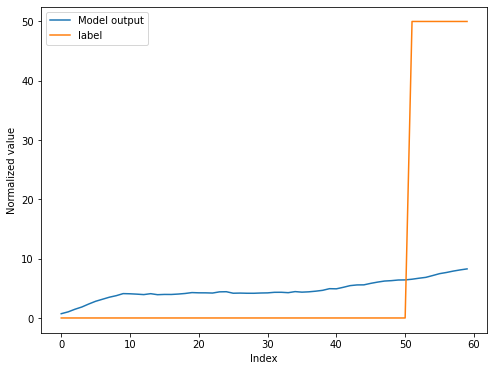

In [28]:
plt.plot(output[-pred_horizon:], label='Model output')
plt.plot(label_test[-pred_horizon:], label='label')


plt.ylabel('Normalized value')
plt.xlabel('Index')
plt.legend()
plt.show()

In [29]:
mean_squared_error(label_test[-pred_horizon:], output[-pred_horizon:])

288.6676850259321

In [30]:
attention_weights = model.encoder_attention(src, layer_idx=0)[0][0]
attention_weights = attention_weights.cpu().detach().numpy()
attention_weights.shape

(2, 120, 120)

In [31]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=[f'Attention head {i}' for i in range(attention_weights.shape[0])],
                    x_title='Input time steps',
                    y_title='Output time steps')

for i, head_attn in enumerate(attention_weights):
    head_attn = head_attn/np.max(head_attn.flatten())
    fig.add_trace(
        go.Heatmap(z=head_attn), row=1, col=i+1)

fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    font=dict(
    family="Times new Roman",
    size=18),
    template='seaborn',
    title='Attention matrix per head',
)
fig['layout']['yaxis']['autorange'] = "reversed"
fig['layout']['yaxis2']['autorange'] = "reversed"
fig.update_annotations(font=dict(
    family="Times new Roman",
    size=20))
fig.show()

In [68]:
def get_feat_label(dataset, n_tests, stride):
    entry_test = np.zeros((n_tests,int(feat_win+label_win)))
    label_test = np.zeros((n_tests,int(feat_win+label_win)))
    stride_i = 0 + stride
    for entry, label in zip(entry_test, label_test):
        entry[:feat_win] =  dataset[stride_i:feat_win+stride_i]
        label[:feat_win] = dataset[stride_i:feat_win+stride_i]
        label[label_win:] = dataset[feat_win+stride_i:feat_win+stride_i+label_win]
        stride_i += stride
        print(stride_i)

    return entry_test, label_test

entries, labels = get_feat_label(data_test, 2, 15)



30
45


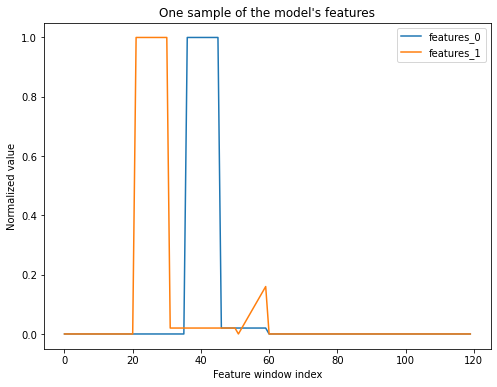

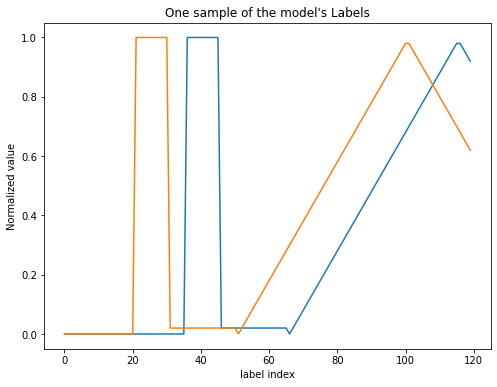

In [69]:
for i, entry in enumerate(entries):
    plt.plot(entry, label=f'features_{i}')
plt.ylabel('Normalized value')
plt.xlabel('Feature window index')
plt.title("One sample of the model's features")
plt.legend()
plt.show()

for i, label in enumerate(labels):
    plt.plot(label, label=f'label_{i}')
plt.ylabel('Normalized value')
plt.xlabel('label index')
plt.title("One sample of the model's Labels")
plt.show()

In [113]:
test_sets = TransformerSet(entries, labels, entries.shape[1], encoder_only=True)
model.eval()
src, true_target = test_sets[1]
src = Variable(torch.Tensor([src])).to(device)
output = model(src).cpu().view(-1)
output = output.detach().numpy().reshape(len(output),1)
output = scaler.inverse_transform(output).flatten()

In [114]:
label_test = true_target
label_test = label_test.reshape(len(label_test),1)
label_test = scaler.inverse_transform(label_test).flatten()

In [115]:
output.shape

(120,)

In [116]:
plot_df ={'prediction_index': np.arange(pred_horizon),
          'pred': output[-pred_horizon:],
          'label': label_test[-pred_horizon:],
          'error': output[-pred_horizon:]-label_test[-pred_horizon:]}

fig = px.line(plot_df, x='prediction_index', y=['pred','label','error'], width=600, height=600)
fig.update_layout(
    legend=dict(
        x=1,
        y=1,
        traceorder="reversed",
        font=dict(
            size=15,
        ),
        bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=2
    )
)
fig.update_layout(
    autosize=False,
    width=600,
    height=600,
    yaxis=dict(
        title_text="Normalized Value",
    ),
    xaxis=dict(title_text="Index"),
    font=dict(
    family="Times new Roman",
    size=18),
    template='seaborn'
)
fig.show()

In [117]:
plot_df ={'prediction_index': np.arange(int(pred_horizon*2)),
          'pred': np.hstack((np.zeros(pred_horizon),output[-pred_horizon:])),
          'input': np.hstack((label_test[:pred_horizon], np.zeros(pred_horizon))),
          'label': np.hstack((np.zeros(pred_horizon), label_test[-pred_horizon:])),
          'error': output-label_test}

fig = px.line(plot_df, x='prediction_index', y=['pred','label', 'input'], width=600, height=600)
fig.update_layout(
    legend=dict(
        x=1,
        y=1,
        traceorder="reversed",
        font=dict(
            size=15,
        ),
        bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=2
    )
)
fig.update_layout(
    autosize=False,
    width=600,
    height=600,
    yaxis=dict(
        title_text="Signal value",
    ),
    xaxis=dict(title_text="Index"),
    font=dict(
    family="Times new Roman",
    size=18),
    template='seaborn'
)
fig.show()

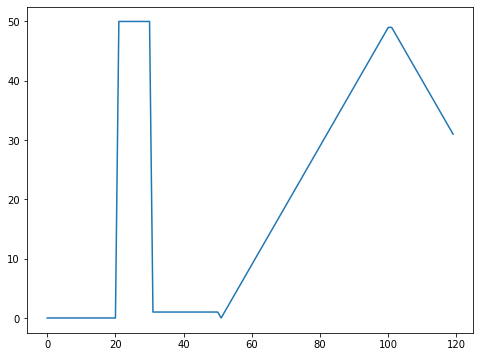

In [118]:
plt.plot(label_test)

In [119]:
attention_weights = model.encoder_attention(src, layer_idx=0)[0][0]
attention_weights = attention_weights.cpu().detach().numpy()
attention_weights.shape


(2, 120, 120)

In [120]:
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=[f'Attention head {i}' for i in range(attention_weights.shape[0])],
                    x_title='Input time steps',
                    y_title='Output time steps')

for i, head_attn in enumerate(attention_weights):
    head_attn = head_attn/np.max(head_attn.flatten())
    fig.add_trace(
        go.Heatmap(z=head_attn), row=1, col=i+1)

fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    font=dict(
    family="Times new Roman",
    size=18),
    template='seaborn',
    title='Attention matrix per head',
)
fig['layout']['yaxis']['autorange'] = "reversed"
fig['layout']['yaxis2']['autorange'] = "reversed"
fig.update_annotations(font=dict(
    family="Times new Roman",
    size=20))
fig.show()

In [121]:
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=[f'Attention head {i}' for i in range(attention_weights.shape[0])],
                    x_title='Input time steps',
                    y_title='Output time steps')

for i, head_attn in enumerate(attention_weights):
    head_attn = head_attn/np.max(head_attn.flatten())
    head_attn = head_attn[feat_win:, :feat_win]
    fig.add_trace(
        go.Heatmap(z=head_attn), row=1, col=i+1)

fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    font=dict(
    family="Times new Roman",
    size=18),
    template='seaborn',
    title='Attention matrix per head',
)
fig['layout']['yaxis']['autorange'] = "reversed"
fig['layout']['yaxis2']['autorange'] = "reversed"
fig.update_annotations(font=dict(
    family="Times new Roman",
    size=20))
fig.show()

In [122]:
# df = {}
# entry = src.cpu().view(-1).detach().numpy()
# entry = entry[:len(entry)//2]
# label_test = true_target[-pred_horizon:]
# for (i in range(len(entry)):
#     df[f'i{i}'] = entry[i]
#     df[f'o{i}'] = label_test[i]

# fig = px.imshow(df.corr(), text_auto=True ,color_continuous_scale='PuBu', width=1000, height=800, aspect="auto")
# fig.show()

In [123]:
from scipy.signal import find_peaks
# indices = find_peaks(result_attn)[0]

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=[f'Attention head {i}' for i in range(attention_weights.shape[0])],
                    x_title='Input time steps',
                    y_title='Summed attention')

all_peaks_indices = np.array([])
for i, head_attn in enumerate(attention_weights):
    head_attn = head_attn/np.max(head_attn.flatten())
    head_attn = head_attn[feat_win:, :feat_win]
    result_attn = head_attn.sum(axis=0)
    indices = find_peaks(result_attn, distance = 15,)[0]
    fig.add_trace(go.Scatter(
    y=result_attn,
    mode='lines+markers',
    name=f'Head {i}'),
    row=1, col=i+1)

    for idx in indices:
        xref = f'x{i+1}' if i > 0 else 'x'
        yref = f'y{i+1}' if i > 0 else 'y'
        fig.add_annotation(
                x=idx,
                y=result_attn[idx],
                xref=xref,
                yref=yref,
                text=f"<b>Attention Peak at<b> {idx}",
                showarrow=True,
                font=dict(
                    size=16,
                    ),
                align="center",
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor="Red",
                ax=-30,
                ay=-30,
                bordercolor="Black",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=0.8
                )
    all_peaks_indices = np.concatenate((all_peaks_indices, indices), axis=0)

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    font=dict(
    family="Times new Roman",
    size=18),
    template='seaborn',
    title='Summed attention per head',

)
# fig = px.line(plot_df, x='entry_index', y=['entry'])
fig.show()

In [124]:
all_peaks_indices = all_peaks_indices.astype(np.int32)

In [125]:
entry = src.cpu().view(-1).detach().numpy()
entry = entry[:len(entry)//2]

fig = go.Figure()
fig.add_trace(go.Scatter(
    y=entry,
    mode='lines+markers',
    name='entries'
))
for i in all_peaks_indices:
    fig.add_annotation(
            x=i,
            y=entry[i],
            xref="x",
            yref="y",
            text=f"<b>Attention Peak at<b> {i}",
            showarrow=True,
            font=dict(
                size=16,
                ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="Red",
            ax=20,
            ay=+40,
            bordercolor="Black",
            borderwidth=2,
            borderpad=4,
            bgcolor="#ff7f0e",
            opacity=0.8
            )
fig.update_layout(
    autosize=False,
    width=600,
    height=600,
    yaxis=dict(
        title_text="Entries",
    ),
    xaxis=dict(title_text="Index"),
    font=dict(
    family="Times new Roman",
    size=18),
    template='seaborn'
)
fig.show()


In [126]:
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=[f'Attention head {i}' for i in range(attention_weights.shape[0])],
                    x_title='Time steps',
                    y_title='Input')

for i, head_attn in enumerate(attention_weights):
    head_attn = head_attn/np.max(head_attn.flatten())
    head_attn = head_attn[feat_win:, :feat_win]
    result_attn = head_attn.sum(axis=0)
    result_attn = result_attn/np.max(result_attn)
    # result_attn = np.vstack([result_attn] * 60)
    fig.add_trace(go.Scatter(
    y=entry,
    mode='lines+markers',
    name='entries',
    line=dict(color="#353b43"),
    marker=dict(size=10, color=result_attn, showscale=True if i<1 else False), ), row=1, col=i+1)
    # fig.add_trace(go.Heatmap(z=result_attn, x=np.arange(len(entry)),
    #                          y=np.linspace(np.min(entry),np.max(entry), len(entry)),
    #                          showscale=True if i<1 else False), row=1, col=i+1)

fig.update_annotations(font=dict(
    family="Times new Roman",
    size=20))
fig.update_layout(showlegend=False)
fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    font=dict(
    family="Times new Roman",
    size=18),
    title='Inputs with the Summed attention head 1',
    template='plotly_dark'
)
fig.show()


In [112]:
auto_corr = statsmodels.tsa.stattools.acf(entry, nlags = 60, fft=False)
valleys_idx = find_peaks(auto_corr*-1)[0]

indices = find_peaks(auto_corr)[0]

fig = go.Figure()
fig.add_trace(go.Scatter(
    y=auto_corr,
    mode='lines+markers',
    name='Original Plot'
))

for i in indices:
    fig.add_annotation(
            x=i,
            y=auto_corr[i],
            xref="x",
            yref="y",
            text=f"<b>Peak at<b> {i}",
            showarrow=True,
            font=dict(
                size=16,
                ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="Red",
            ax=20,
            ay=-40,
            bordercolor="Black",
            borderwidth=2,
            borderpad=4,
            bgcolor="#ff7f0e",
            opacity=0.8
            )

for i in valleys_idx:
    fig.add_annotation(
            x=i,
            y=auto_corr[i],
            xref="x",
            yref="y",
            text=f"<b>Valley at<b> {i}",
            showarrow=True,
            font=dict(
                size=16,
                ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="Blue",
            ax=20,
            ay=+40,
            bordercolor="Black",
            borderwidth=2,
            borderpad=4,
            bgcolor="#ff7f0e",
            opacity=0.8
            )

fig.update_layout(
    autosize=False,
    width=600,
    height=600,
    yaxis=dict(
        title_text="Entries Pearson Autocorelation",
    ),
    xaxis=dict(title_text="Index"),
    font=dict(
    family="Times new Roman",
    size=18),
    template='seaborn'
)

fig.show()


## Using shap to better understand the predictions

In [49]:
import shap

In [50]:
src, target =  next(iter(train_loader))
src = src.to(torch.float32)
src = src.to(device)

In [51]:
explainer = shap.DeepExplainer(model, src)

In [52]:
src, target =  next(iter(test_loader))
src = src.to(torch.float32)
src = src.to(device)

In [53]:
src.shape

torch.Size([1, 120, 1])

In [54]:
shap_values = explainer.shap_values(src)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [55]:
len(shap_values)
shap_values_mtx = np.array([np.abs(i.flatten()) for i in shap_values])[feat_win:, :feat_win]

In [56]:
fig = go.Figure(data=go.Heatmap(z=shap_values_mtx))

fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    font=dict(
    family="Times new Roman",
    size=18),
    template='seaborn',
    title='Absolute Shap values matrix',
)
fig['layout']['yaxis']['autorange'] = "reversed"
fig.update_annotations(font=dict(
    family="Times new Roman",
    size=20))
fig.show()

In [57]:
result_attn = shap_values_mtx.sum(axis=0)
result_attn = result_attn/np.max(result_attn)
fig = go.Figure(data = go.Scatter(
    y=entry,
    mode='lines+markers',
    name='entries',
    line=dict(color="#353b43"),
    marker=dict(size=10, color=result_attn, showscale=True) ))


fig.update_annotations(font=dict(
    family="Times new Roman",
    size=20))
fig.update_layout(showlegend=False)
fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    font=dict(
    family="Times new Roman",
    size=18),
    title='Summed abs SHAP values',
    template='plotly_dark'
)
fig.show()
